In [68]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor

data = pd.read_csv("Data.csv")

In [39]:
data = data.drop(['Stroke(AIS,TIA,AHS)'], axis=1)

In [57]:
X_train = data.dropna().ix[:, data.columns != 'DisNeuro01']
Y_train = data.dropna().ix[:, data.columns == 'DisNeuro01']

X_test = data.dropna().ix[55:, data.columns != 'DisNeuro01']
Y_test = data.dropna().ix[55:, data.columns == 'DisNeuro01']

In [71]:
rf = RandomForestRegressor(oob_score=True)
rf.fit(X_train, Y_train.values.ravel())
a = rf.predict(X_test)


importances = rf.feature_importances_
std = np.std([tree.feature_importances_ for tree in rf.estimators_],axis=0)
indices = np.argsort(importances)[::-1]

for f in range(X_train.shape[1]):
    print("%d. feature %d (%f)" % (f + 1, indices[f], importances[indices[f]]))

1. feature 1 (0.099607)
2. feature 11 (0.077357)
3. feature 9 (0.073330)
4. feature 17 (0.071140)
5. feature 7 (0.068179)
6. feature 19 (0.062750)
7. feature 2 (0.058454)
8. feature 20 (0.054631)
9. feature 10 (0.049343)
10. feature 18 (0.048569)
11. feature 16 (0.045839)
12. feature 15 (0.045649)
13. feature 12 (0.040624)
14. feature 21 (0.034419)
15. feature 22 (0.029855)
16. feature 4 (0.028742)
17. feature 6 (0.026364)
18. feature 5 (0.020897)
19. feature 8 (0.019844)
20. feature 0 (0.017010)
21. feature 14 (0.014516)
22. feature 13 (0.012882)
23. feature 3 (0.000000)


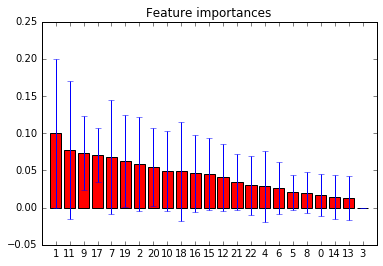

In [75]:
plt.title("Feature importances")
plt.bar(range(X_train.shape[1]), importances[indices],
       color="r", yerr=std[indices], align="center")
plt.xticks(range(X_train.shape[1]), indices)
plt.xlim([-1, X_train.shape[1]])
plt.show()